<a href="https://colab.research.google.com/github/mashaan14/YouTube-channel/blob/main/notebooks/2024_05_13_DGL_GAT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Graph Attention Networks in DGL

## Acknowledgment:
- [Official DGL Examples and Modules](https://github.com/dmlc/dgl/tree/master/examples/pytorch/gat)
- [GATConv in dgl.nn](https://docs.dgl.ai/en/0.8.x/generated/dgl.nn.pytorch.conv.GATConv.html)


## References:
```bibtex
@article{wang2019dgl,
 title    ={Deep Graph Library: A Graph-Centric, Highly-Performant Package for Graph Neural Networks},
 author   ={Minjie Wang and Da Zheng and Zihao Ye and Quan Gan and Mufei Li and Xiang Song and Jinjing Zhou and Chao Ma and Lingfan Yu and Yu Gai and Tianjun Xiao and Tong He and George Karypis and Jinyang Li and Zheng Zhang},
 year     ={2019},
 journal  ={arXiv preprint arXiv:1909.01315}
}
```

```bibtex
@article{velickovic2018graph,
 title    ="{Graph Attention Networks}",
author    ={Veli{\v{c}}kovi{\'{c}}, Petar and Cucurull, Guillem and Casanova, Arantxa and Romero, Adriana and Li{\`{o}}, Pietro and Bengio, Yoshua},
journal   ={International Conference on Learning Representations},
year      ={2018},
}
```

In [ ]:
!pip install dgl

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.5/8.5 MB 24.0 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.19.3-py3-none-manylinux1_x86_64.whl (166.0 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-manylin

## Import libraries

In [ ]:
import numpy as np
from IPython.display import Javascript  # Restrict height of output cell.

import torch
import torch.nn as nn
import torch.nn.functional as F

import dgl
import dgl.nn as dglnn
from dgl import AddSelfLoop
from dgl.data import CoraGraphDataset

DGL backend not selected or invalid.  Assuming PyTorch for now.


Setting the default backend to "pytorch". You can change it in the ~/.dgl/config.json file or export the DGLBACKEND environment variable.  Valid options are: pytorch, mxnet, tensorflow (all lowercase)


## GAT layers from DGL

In [ ]:
class GAT(nn.Module):
    def __init__(self, in_size, hid_size, out_size, heads):
        super().__init__()
        self.gat_layers = nn.ModuleList()
        # two-layer GAT
        self.gat_layers.append(
            dglnn.GATConv(
                in_size,
                hid_size,
                heads[0],
                feat_drop=0.6,
                attn_drop=0.6,
                activation=F.elu,
            )
        )
        self.gat_layers.append(
            dglnn.GATConv(
                hid_size * heads[0],
                out_size,
                heads[1],
                feat_drop=0.6,
                attn_drop=0.6,
                activation=None,
            )
        )

    def forward(self, g, inputs):
        h = inputs
        for i, layer in enumerate(self.gat_layers):
            h = layer(g, h)
            if i == 1:  # last layer
                h = h.mean(1)
            else:  # other layer(s)
                h = h.flatten(1)

        return h

## How GAT class processes data?

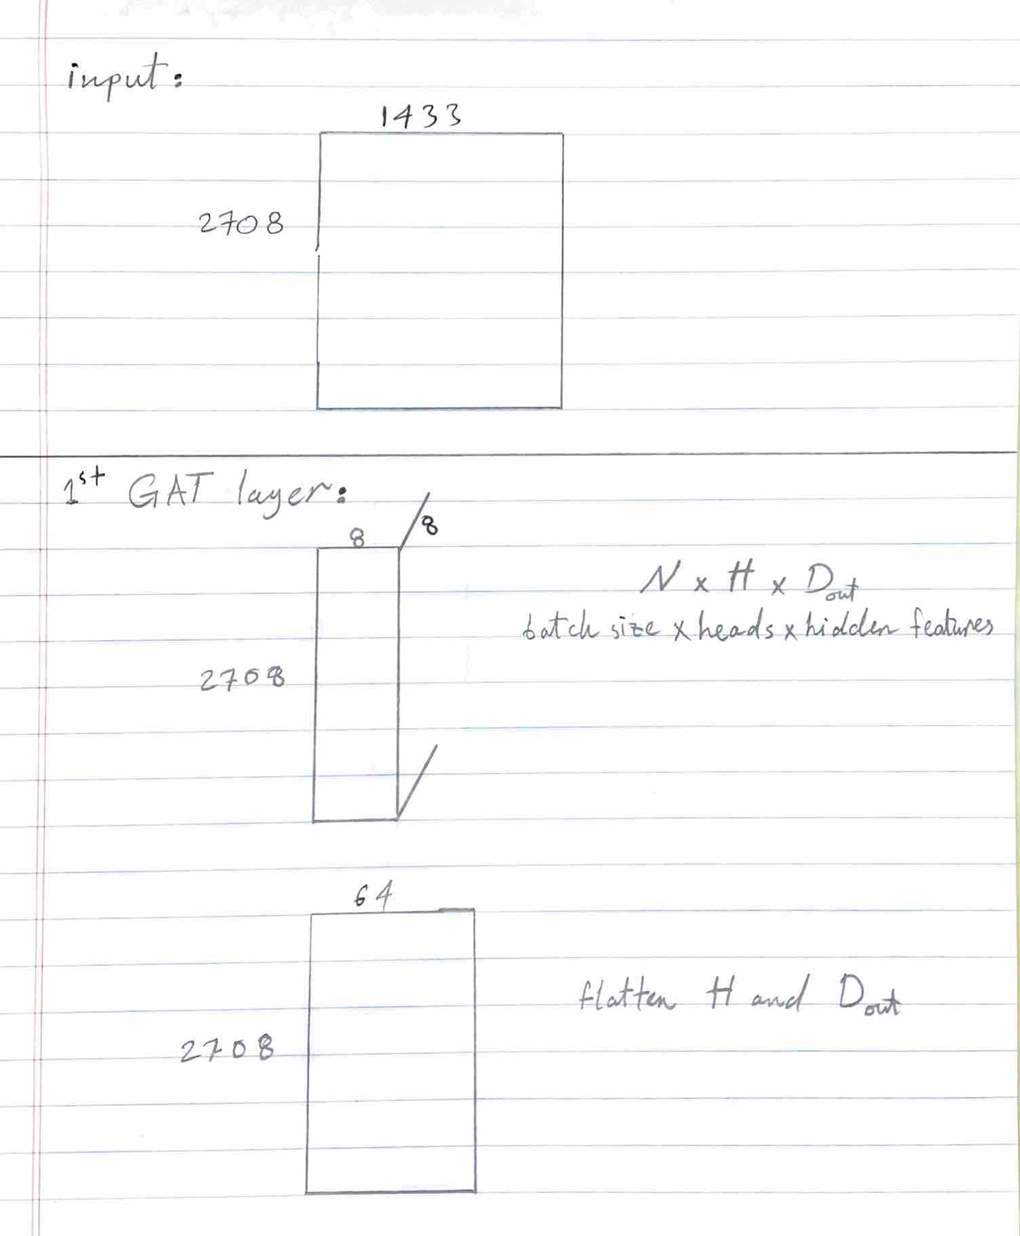

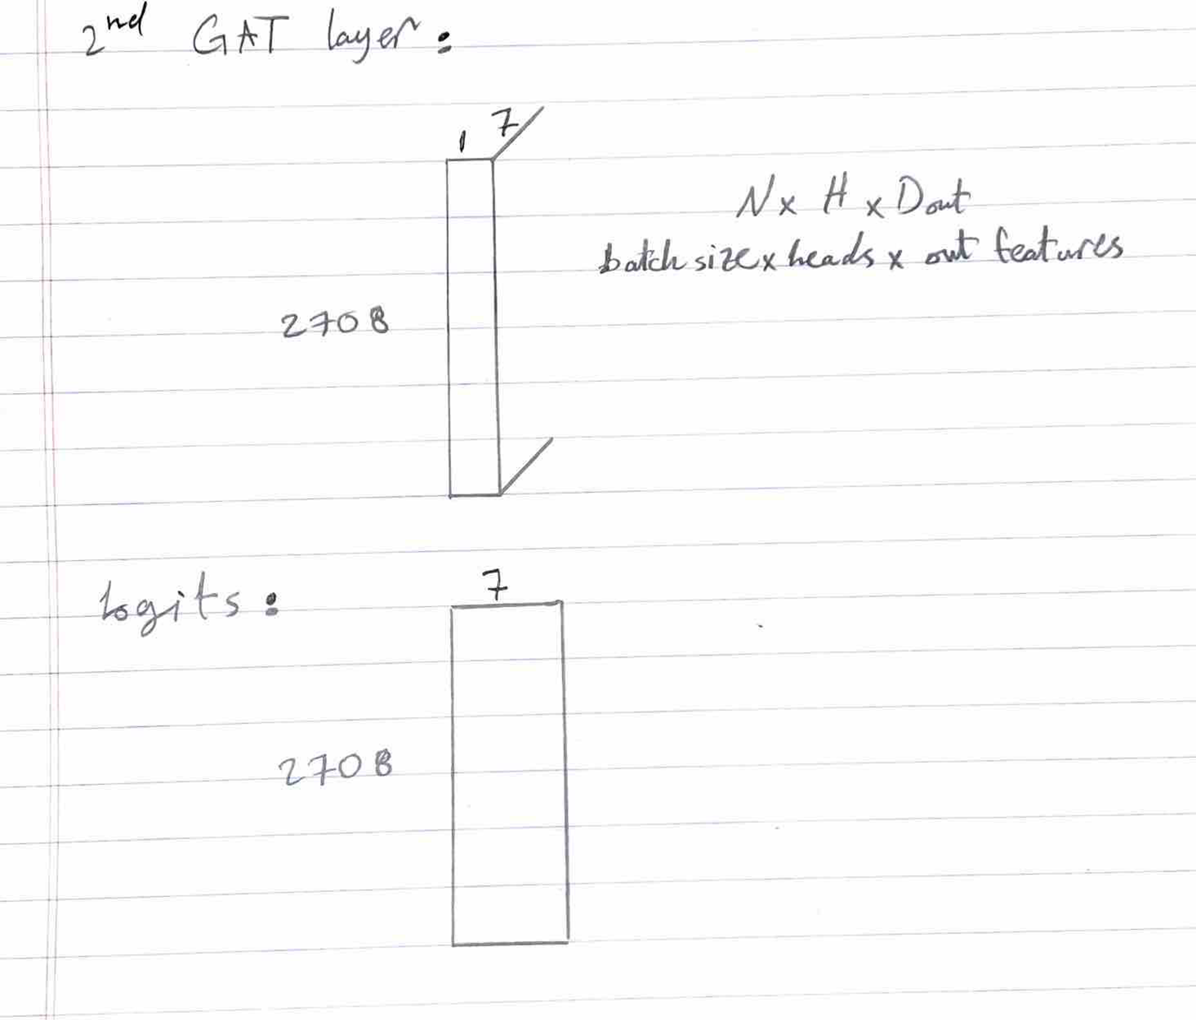

## What happened in the $1^{st}$ GAT layer?

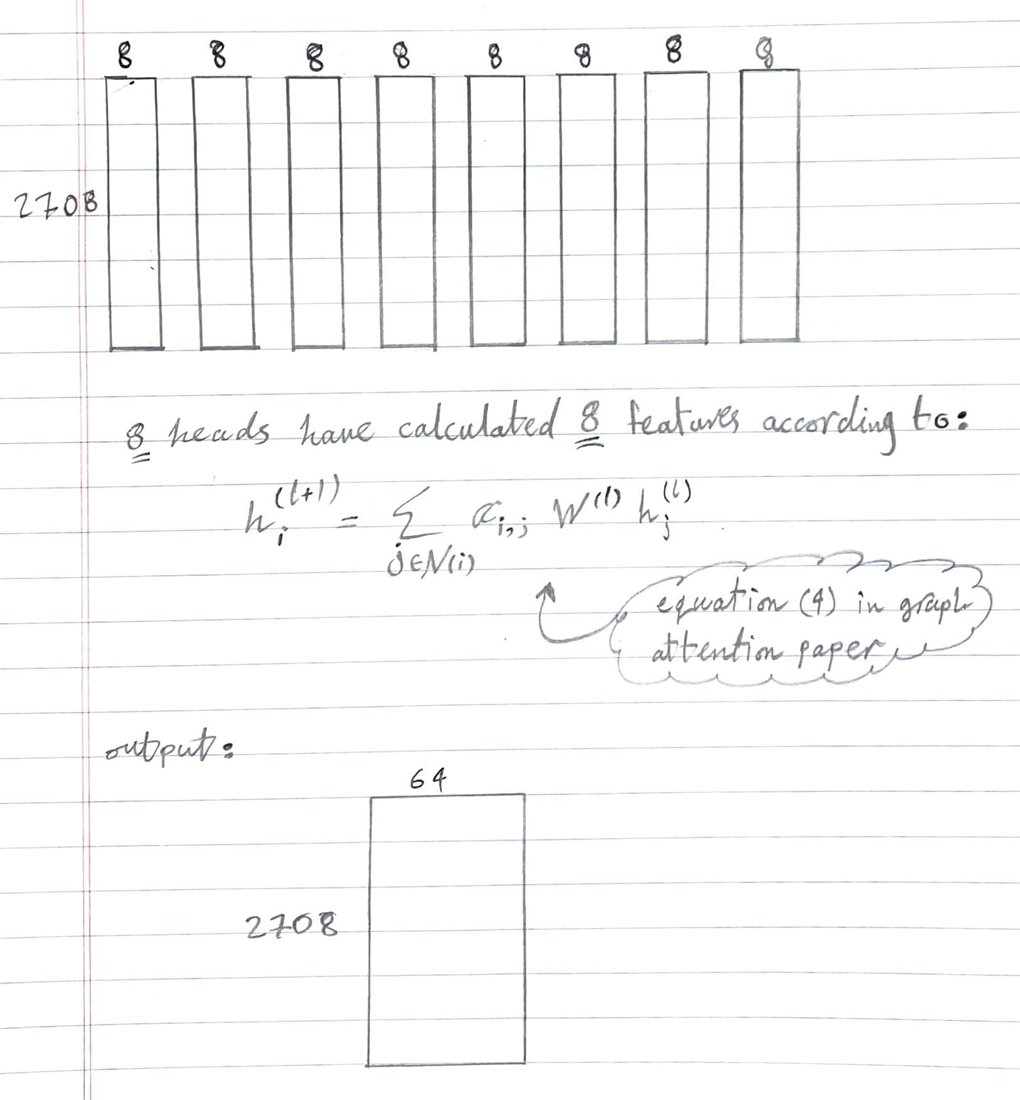

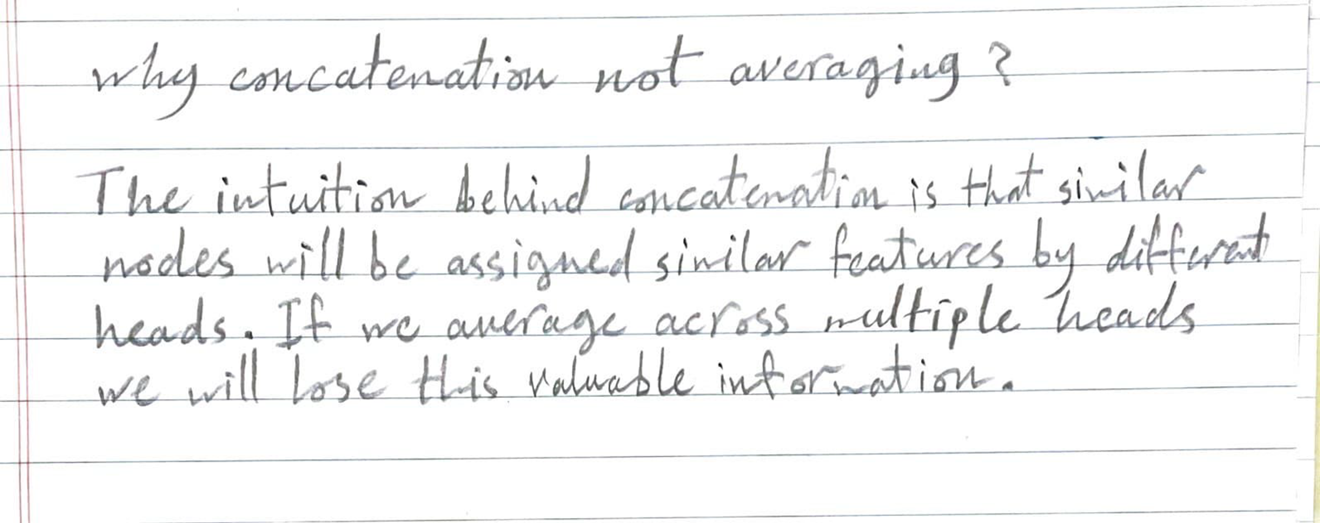

## Evaluate and train functions

In [ ]:
def evaluate(g, features, labels, mask, model):
    model.eval()
    with torch.no_grad():
        logits = model(g, features)
        logits = logits[mask]
        labels = labels[mask]
        _, indices = torch.max(logits, dim=1)
        correct = torch.sum(indices == labels)
        return correct.item() * 1.0 / len(labels)

In [ ]:
def train(g, features, labels, masks, model, epochs):
    # define train/val samples, loss function and optimizer
    train_mask = masks[0]
    val_mask = masks[1]
    loss_fcn = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=5e-3, weight_decay=5e-4)

    # training loop
    for epoch in range(epochs):
        model.train()
        logits = model(g, features)
        loss = loss_fcn(logits[train_mask], labels[train_mask])
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        acc = evaluate(g, features, labels, val_mask, model)
        print(
            "Epoch {:05d} | Loss {:.4f} | Accuracy {:.4f} ".format(
                epoch, loss.item(), acc
            )
        )

## Import Cora Dataset

In [ ]:
# load and preprocess dataset
transform = (AddSelfLoop())
data = CoraGraphDataset(transform=transform)
g = data[0]

/root/.dgl/cora_v2.zip:   0%|          | 0.00/132k [00:00<?, ?B/s]

Extracting file to /root/.dgl/cora_v2_d697a464
Finished data loading and preprocessing.
  NumNodes: 2708
  NumEdges: 10556
  NumFeats: 1433
  NumClasses: 7
  NumTrainingSamples: 140
  NumValidationSamples: 500
  NumTestSamples: 1000
Done saving data into cached files.


## Initialize the model

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
g = g.int().to(device)
features = g.ndata["feat"]
labels = g.ndata["label"]
masks = g.ndata["train_mask"], g.ndata["val_mask"], g.ndata["test_mask"]

# create GAT model
in_size = features.shape[1]
out_size = data.num_classes
model = GAT(in_size, 8, out_size, heads=[8, 1]).to(device)

## Training

In [ ]:
# model training
display(Javascript('''google.colab.output.setIframeHeight(0, true, {maxHeight: 300})'''))
print("Training...")
train(g, features, labels, masks, model, epochs=200)

<IPython.core.display.Javascript object>

Training...
Epoch 00000 | Loss 1.9459 | Accuracy 0.2700 
Epoch 00001 | Loss 1.9391 | Accuracy 0.2940 
Epoch 00002 | Loss 1.9244 | Accuracy 0.3300 
Epoch 00003 | Loss 1.9186 | Accuracy 0.3080 
Epoch 00004 | Loss 1.8923 | Accuracy 0.3780 
Epoch 00005 | Loss 1.9063 | Accuracy 0.4540 
Epoch 00006 | Loss 1.8913 | Accuracy 0.5700 
Epoch 00007 | Loss 1.8876 | Accuracy 0.6380 
Epoch 00008 | Loss 1.8661 | Accuracy 0.6860 
Epoch 00009 | Loss 1.8739 | Accuracy 0.7200 
Epoch 00010 | Loss 1.8432 | Accuracy 0.7120 
Epoch 00011 | Loss 1.8456 | Accuracy 0.7000 
Epoch 00012 | Loss 1.8447 | Accuracy 0.7180 
Epoch 00013 | Loss 1.8322 | Accuracy 0.7100 
Epoch 00014 | Loss 1.8145 | Accuracy 0.6920 
Epoch 00015 | Loss 1.8104 | Accuracy 0.6780 
Epoch 00016 | Loss 1.8045 | Accuracy 0.6760 
Epoch 00017 | Loss 1.7812 | Accuracy 0.6760 
Epoch 00018 | Loss 1.7964 | Accuracy 0.6780 
Epoch 00019 | Loss 1.7548 | Accuracy 0.6800 
Epoch 00020 | Loss 1.7550 | Accuracy 0.6760 
Epoch 00021 | Loss 1.7609 | Accuracy 0.6900

## Testing

In [ ]:
# test the model
print("Testing...")
acc = evaluate(g, features, labels, masks[2], model)
print("Test accuracy {:.4f}".format(acc))

Testing...
Test accuracy 0.8220
